In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
import scipy.stats as ss

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

import lightgbm as lgbm

import optuna

In [2]:
# https://www.kaggle.com/datasets/blastchar/telco-customer-churn
churn_records = pd.read_csv('dataset.csv')

In [3]:
churn_records

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [4]:
churn_records['TotalCharges'] = churn_records['TotalCharges'].replace(' ', None)

In [5]:
churn_records['SeniorCitizen'] = churn_records['SeniorCitizen'].astype(object)
churn_records['TotalCharges'] = churn_records['TotalCharges'].astype(float)

In [6]:
for column in churn_records.select_dtypes(object).columns:
    churn_records[column] = churn_records[column].astype('category')

In [7]:
churn_records.dtypes

customerID          category
gender              category
SeniorCitizen       category
Partner             category
Dependents          category
tenure                 int64
PhoneService        category
MultipleLines       category
InternetService     category
OnlineSecurity      category
OnlineBackup        category
DeviceProtection    category
TechSupport         category
StreamingTV         category
StreamingMovies     category
Contract            category
PaperlessBilling    category
PaymentMethod       category
MonthlyCharges       float64
TotalCharges         float64
Churn               category
dtype: object

In [8]:
churn_records.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [9]:
categorical_columns = churn_records.drop(columns=['customerID', 'Churn']).select_dtypes('category').columns.to_list() 
continuous_columns = churn_records.select_dtypes([int, float]).columns.to_list()

In [10]:
churn_records.value_counts('Churn', normalize=True)

Churn
No     0.73463
Yes    0.26537
dtype: float64

In [11]:
churn_records

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes


In [12]:
def demonstrate_categorical_metrics(metrics: pd.DataFrame, column:str):
    print(metrics.value_counts(column))
    aggregated_metrics = metrics.groupby([column]).agg({'sales':'mean'}).reset_index()
    plt.figure(figsize=(12, 7))
    ax = sns.barplot(x=column,y='sales',data=aggregated_metrics)
    plt.title(f'{column} Sales Information',fontweight="bold")
    plt.ylabel('sales', fontsize=18)
    plt.xlabel(column, fontsize=16)
    for label in ax.get_xticklabels():
        label.set_rotation(45)

In [13]:
# https://stackoverflow.com/questions/46498455/categorical-features-correlation/46498792#46498792
def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))


Correlation between Churn and gender columns is: 0.0
gender
Male      0.504756
Female    0.495244
dtype: float64


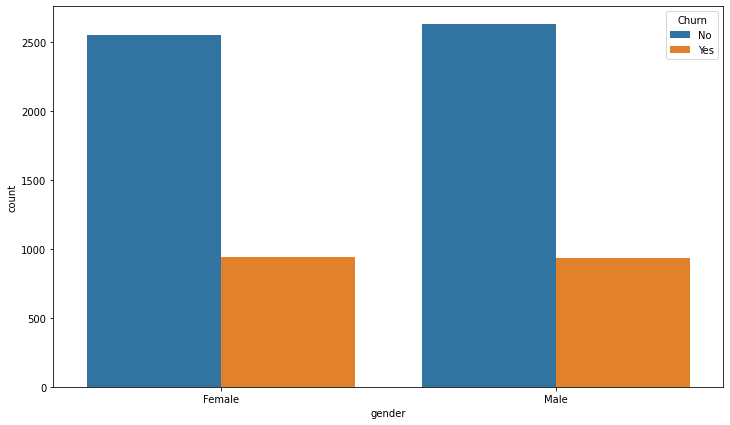

Correlation between Churn and SeniorCitizen columns is: 0.14999108255137
SeniorCitizen
0    0.837853
1    0.162147
dtype: float64


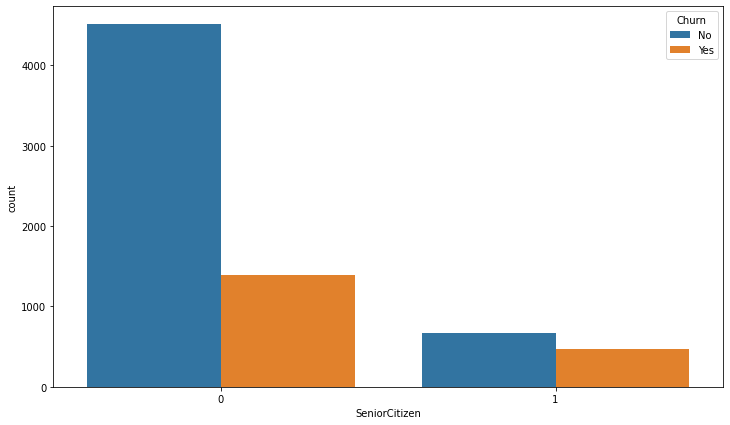

Correlation between Churn and Partner columns is: 0.14966271044155077
Partner
No     0.516967
Yes    0.483033
dtype: float64


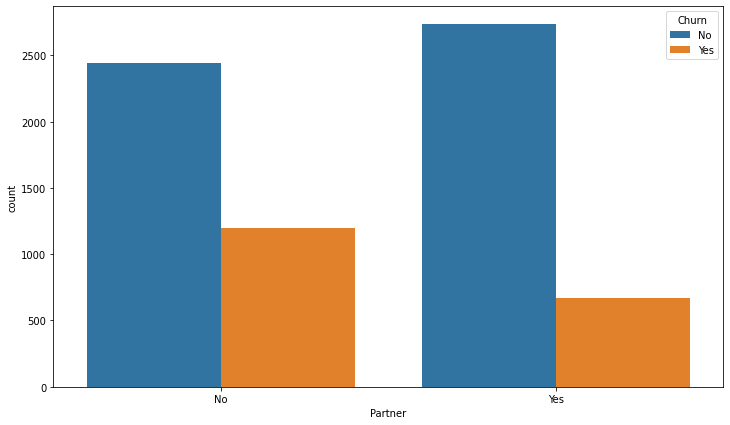

Correlation between Churn and Dependents columns is: 0.1634481432749282
Dependents
No     0.700412
Yes    0.299588
dtype: float64


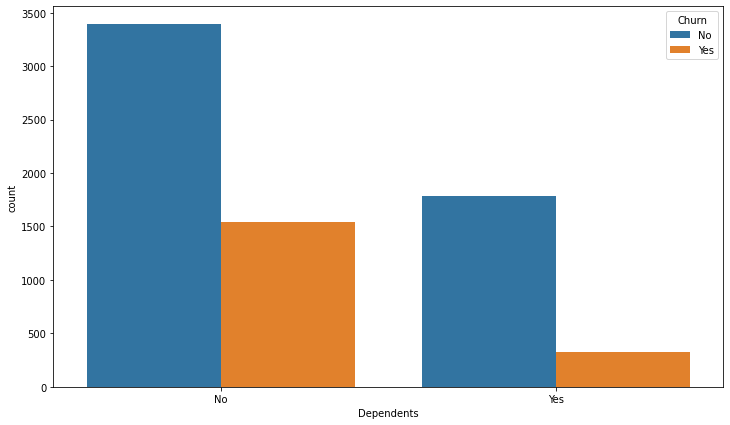

Correlation between Churn and PhoneService columns is: 0.0
PhoneService
Yes    0.903166
No     0.096834
dtype: float64


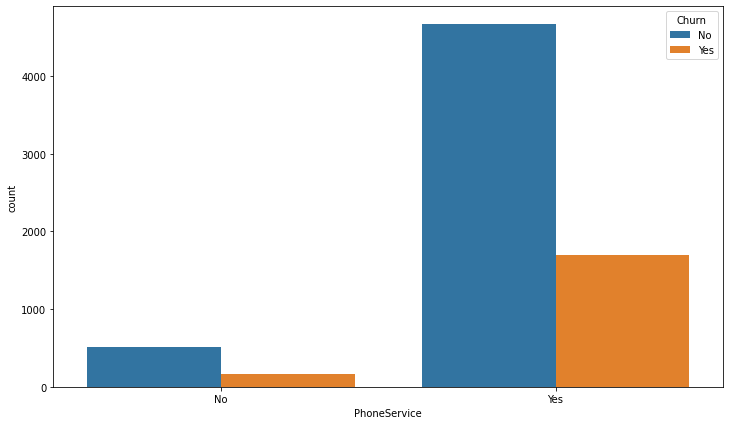

Correlation between Churn and MultipleLines columns is: 0.03639958908232507
MultipleLines
No                  0.481329
Yes                 0.421837
No phone service    0.096834
dtype: float64


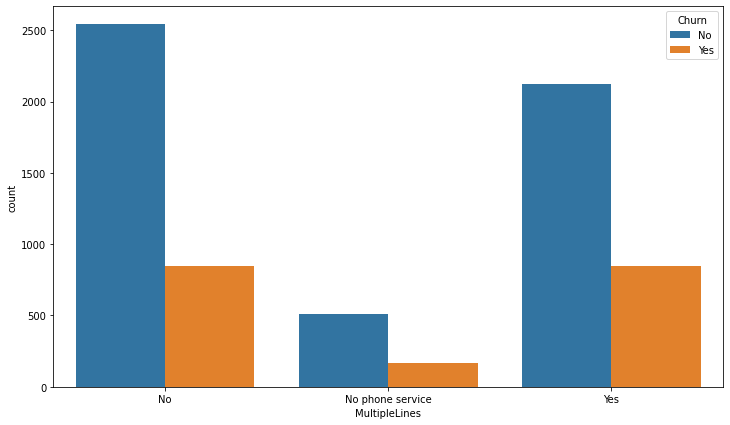

Correlation between Churn and InternetService columns is: 0.3220367323307425
InternetService
Fiber optic    0.439585
DSL            0.343746
No             0.216669
dtype: float64


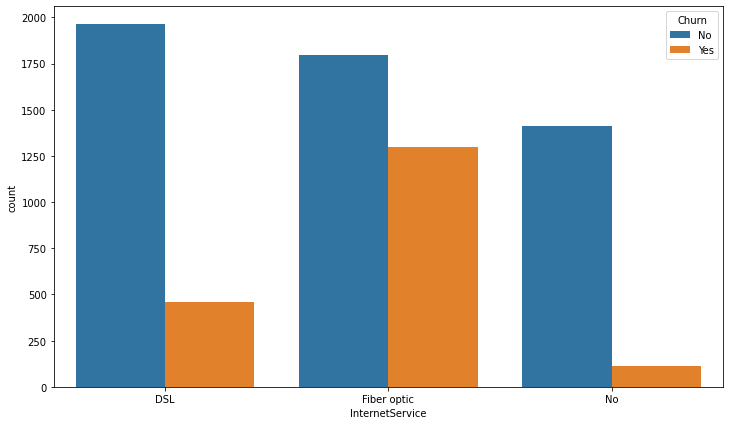

Correlation between Churn and OnlineSecurity columns is: 0.34701606688272874
OnlineSecurity
No                     0.496663
Yes                    0.286668
No internet service    0.216669
dtype: float64


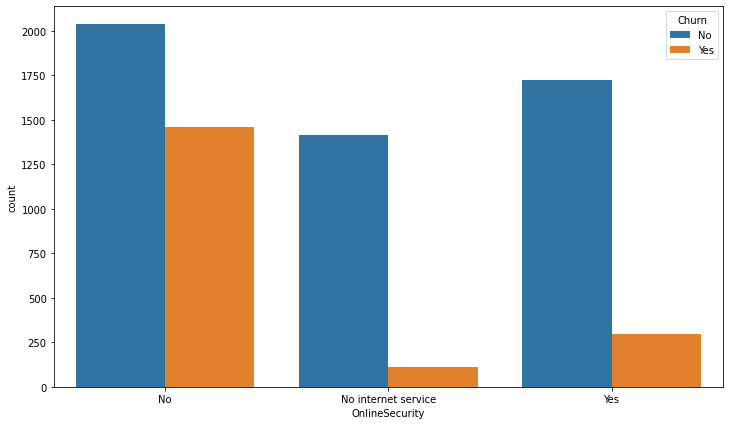

Correlation between Churn and OnlineBackup columns is: 0.291850036724674
OnlineBackup
No                     0.438450
Yes                    0.344881
No internet service    0.216669
dtype: float64


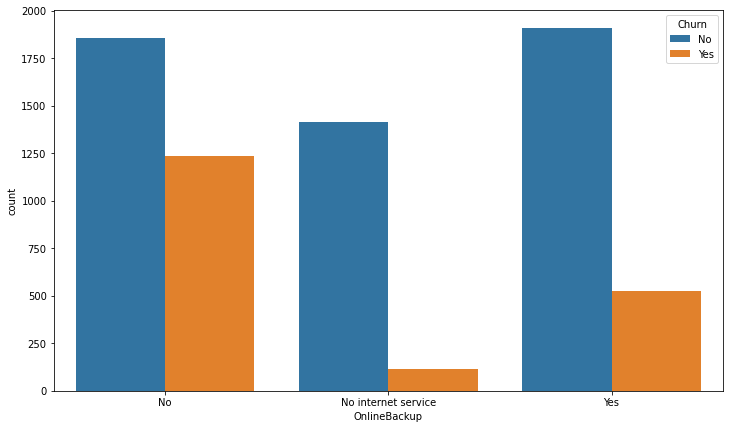

Correlation between Churn and DeviceProtection columns is: 0.28109492388964397
DeviceProtection
No                     0.439443
Yes                    0.343888
No internet service    0.216669
dtype: float64


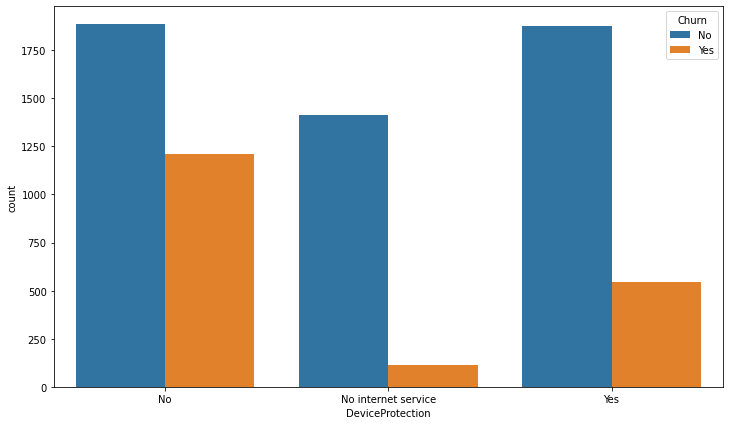

Correlation between Churn and TechSupport columns is: 0.3425261587493695
TechSupport
No                     0.493114
Yes                    0.290217
No internet service    0.216669
dtype: float64


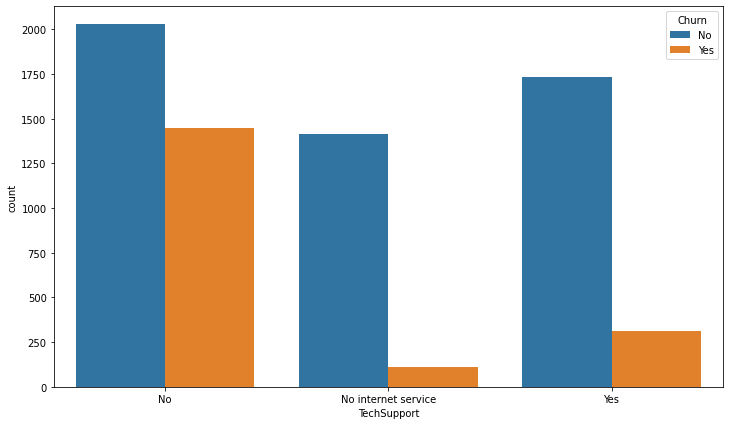

Correlation between Churn and StreamingTV columns is: 0.22990176915403474
StreamingTV
No                     0.398978
Yes                    0.384353
No internet service    0.216669
dtype: float64


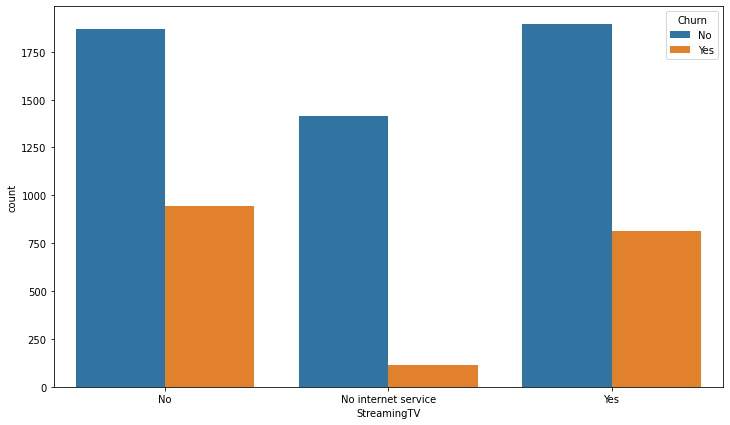

Correlation between Churn and StreamingMovies columns is: 0.23035147282444215
StreamingMovies
No                     0.395428
Yes                    0.387903
No internet service    0.216669
dtype: float64


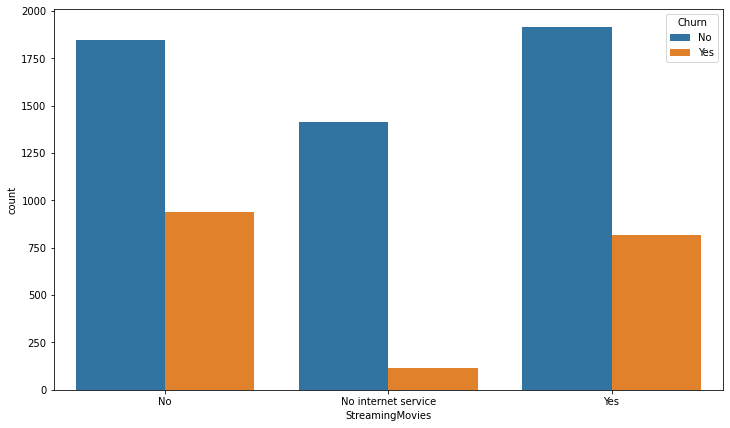

Correlation between Churn and Contract columns is: 0.40979839182553446
Contract
Month-to-month    0.550192
Two year          0.240664
One year          0.209144
dtype: float64


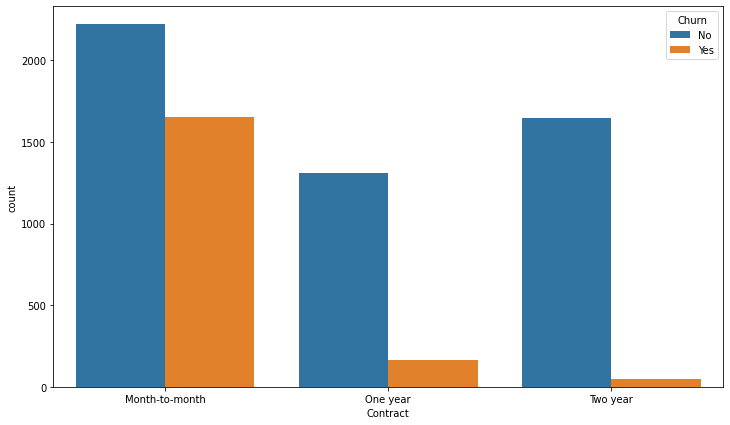

Correlation between Churn and PaperlessBilling columns is: 0.1911405817441778
PaperlessBilling
Yes    0.592219
No     0.407781
dtype: float64


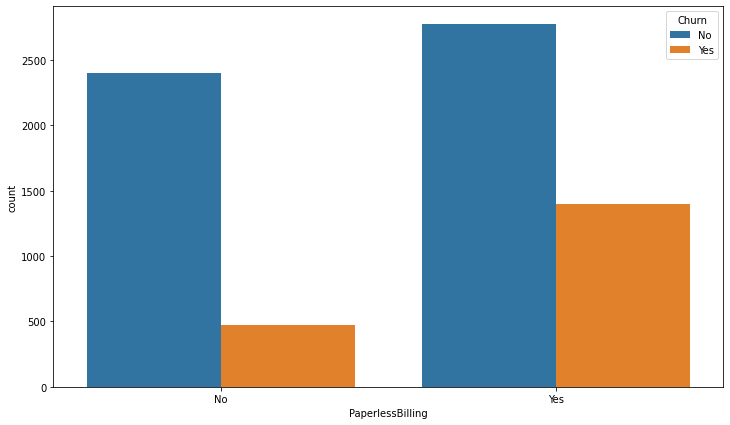

Correlation between Churn and PaymentMethod columns is: 0.3026771381187204
PaymentMethod
Electronic check             0.335794
Mailed check                 0.228880
Bank transfer (automatic)    0.219225
Credit card (automatic)      0.216101
dtype: float64


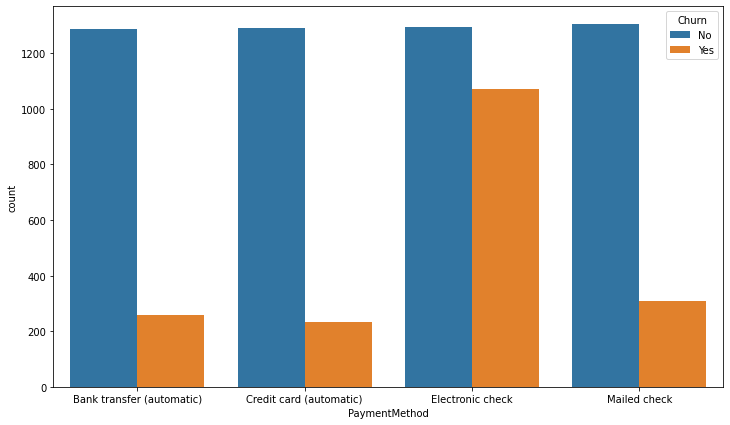

In [14]:
categorical_features_correlations = {}
for column in categorical_columns:
    confusion_matrix = pd.crosstab(churn_records[column], churn_records['Churn'])
    correlation = cramers_v(confusion_matrix.values)
    categorical_features_correlations[column] = correlation
    print(f"Correlation between Churn and {column} columns is: {correlation}")
    
    cramers_v(confusion_matrix.values)
    plt.figure(figsize=(12, 7))
    print(churn_records.value_counts(column) / len(churn_records))
    sns.countplot(data=churn_records, x=column, hue="Churn")
    plt.show()

In [15]:
sorted(categorical_features_correlations.items(), 
       key=lambda x:x[1], 
       reverse=True)

[('Contract', 0.40979839182553446),
 ('OnlineSecurity', 0.34701606688272874),
 ('TechSupport', 0.3425261587493695),
 ('InternetService', 0.3220367323307425),
 ('PaymentMethod', 0.3026771381187204),
 ('OnlineBackup', 0.291850036724674),
 ('DeviceProtection', 0.28109492388964397),
 ('StreamingMovies', 0.23035147282444215),
 ('StreamingTV', 0.22990176915403474),
 ('PaperlessBilling', 0.1911405817441778),
 ('Dependents', 0.1634481432749282),
 ('SeniorCitizen', 0.14999108255137),
 ('Partner', 0.14966271044155077),
 ('MultipleLines', 0.03639958908232507),
 ('gender', 0.0),
 ('PhoneService', 0.0)]

<Figure size 864x504 with 0 Axes>

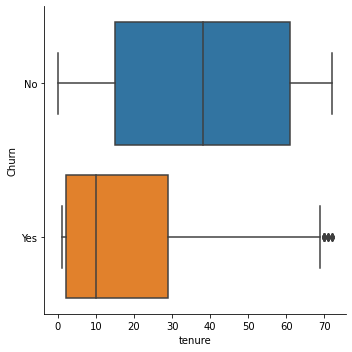

<Figure size 864x504 with 0 Axes>

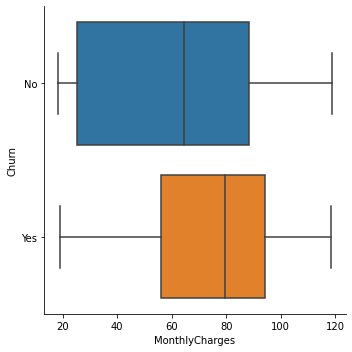

<Figure size 864x504 with 0 Axes>

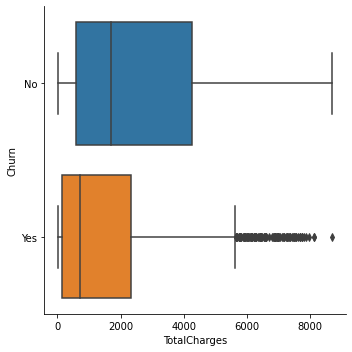

In [16]:
for column in continuous_columns:
    plt.figure(figsize=(12, 7))
    sns.catplot(data=churn_records, x=column, y="Churn", kind="box")
    plt.show()

In [17]:
predictors = ['Contract',
              'OnlineSecurity',
              'TechSupport',
              'InternetService',
              'PaymentMethod',
              'OnlineBackup',
              'DeviceProtection',
              'StreamingMovies',
              'StreamingTV',
              'PaperlessBilling',
              'Dependents',
              'SeniorCitizen',
              'Partner',
              'tenure']

In [18]:
model_data = churn_records[predictors + ['Churn']]

In [19]:
model_data

,Contract,OnlineSecurity,TechSupport,InternetService,PaymentMethod,OnlineBackup,DeviceProtection,StreamingMovies,StreamingTV,PaperlessBilling,Dependents,SeniorCitizen,Partner,tenure,Churn
0,Month-to-month,No,No,DSL,Electronic check,Yes,No,No,No,Yes,No,0,Yes,1,No
1,One year,Yes,No,DSL,Mailed check,No,Yes,No,No,No,No,0,No,34,No
2,Month-to-month,Yes,No,DSL,Mailed check,Yes,No,No,No,Yes,No,0,No,2,Yes
3,One year,Yes,Yes,DSL,Bank transfer (automatic),No,Yes,No,No,No,No,0,No,45,No
4,Month-to-month,No,No,Fiber optic,Electronic check,No,No,No,No,Yes,No,0,No,2,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,One year,Yes,Yes,DSL,Mailed check,No,Yes,Yes,Yes,Yes,Yes,0,Yes,24,No
7039,One year,No,No,Fiber optic,Credit card (automatic),Yes,Yes,Yes,Yes,Yes,Yes,0,Yes,72,No
7040,Month-to-month,Yes,No,DSL,Electronic check,No,No,No,No,Yes,Yes,0,Yes,11,No
7041,Month-to-month,No,No,Fiber optic,Mailed check,No,No,No,No,Yes,No,1,Yes,4,Yes


In [20]:
X_train, X_test, y_train, y_test = train_test_split(model_data[predictors], 
                                                    model_data['Churn'], 
                                                    test_size=0.3, 
                                                    random_state=42)

In [21]:
params = {'reg_alpha': 1.0934329121436712, 
          'reg_lambda': 0.31783786451841517, 
          'colsample_bytree': 1.0, 
          'subsample': 0.4, 
          'learning_rate': 0.008, 
          'max_depth': 7, 
          'n_estimators': 150, 
          'num_leaves': 344, 
          'min_child_samples': 135}

model = lgbm.LGBMClassifier(boosting_type='gbdt', 
                            is_unbalance=True,
                            objective='binary',
                            random_state=42,
                            **params)

model.fit(X_train, y_train)

predictions = model.predict(X_test)
f_score = f1_score(predictions, y_test, average='macro')
print(classification_report(predictions, y_test))

              precision    recall  f1-score   support

          No       0.84      0.89      0.86      1466
         Yes       0.71      0.63      0.67       647

    accuracy                           0.81      2113
   macro avg       0.78      0.76      0.77      2113
weighted avg       0.80      0.81      0.80      2113



In [22]:
def objective(trial):
    train_x, test_x, train_y, test_y = train_test_split(model_data[predictors], 
                                                    model_data['Churn'], 
                                                    test_size=0.3, 
                                                    random_state=42)
    param = {
        'boosting_type':'gbdt', 
        'is_unbalance':True,
        'objective':'binary',
        'random_state':42,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02,0.15,0.1,0.2]),
        'max_depth': trial.suggest_categorical('max_depth', [3, 5, 7, 10,20, 30]),
        'n_estimators': trial.suggest_categorical('n_estimators', [10, 20, 30, 50, 80, 100, 120, 150]),
        'num_leaves' : trial.suggest_int('num_leaves', 10, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300)
    }
    
    model = lgbm.LGBMClassifier(**param)  
    
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)
    f_score = f1_score(predictions, y_test, average='macro')
    return f_score

In [23]:
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=15000)
# print('Number of finished trials:', len(study.trials))
# print('Best trial:', study.best_trial.params)
# print('Best f-score:', study.best_value)

# # Number of finished trials: 15000
# # Best trial: {'reg_alpha': 1.0934329121436712, 'reg_lambda': 0.31783786451841517, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.008, 'max_depth': 7, 'n_estimators': 150, 'num_leaves': 344, 'min_child_samples': 135}
# # Best f-score: 0.7656128674431504

In [24]:
predictor_columns = list(X_test.columns)

In [25]:
probabilities = [prediction[1] for prediction in model.predict_proba(X_test)]

In [26]:
churn_map = {'Yes': 1, 'No': 0}
error_analysis_data = X_test.copy()
error_analysis_data['probability'] = probabilities
error_analysis_data['prediction'] = list(map(churn_map.get, predictions))
error_analysis_data['target'] = list(map(churn_map.get, y_test))
error_analysis_data['target_prediction_match'] = error_analysis_data['target'].eq(error_analysis_data['prediction'])
error_analysis_data['target_probability_diff'] = np.abs(error_analysis_data['target'] - error_analysis_data['probability'])

In [27]:
error_analysis_data['target_probability_diff'].describe()

count    2113.000000
mean        0.342924
std         0.181761
min         0.094597
25%         0.160126
50%         0.341556
75%         0.469953
max         0.905403
Name: target_probability_diff, dtype: float64

In [28]:
error_analysis_data.sort_values('target_probability_diff', ascending=False)

,Contract,OnlineSecurity,TechSupport,InternetService,PaymentMethod,OnlineBackup,DeviceProtection,StreamingMovies,StreamingTV,PaperlessBilling,Dependents,SeniorCitizen,Partner,tenure,probability,prediction,target,target_prediction_match,target_probability_diff
268,Two year,No internet service,No internet service,No,Mailed check,No internet service,No internet service,No internet service,No internet service,No,No,0,No,59,0.094597,0,1,False,0.905403
4513,Two year,Yes,Yes,DSL,Credit card (automatic),Yes,Yes,Yes,Yes,No,Yes,1,Yes,72,0.099125,0,1,False,0.900875
4149,Two year,No,No,DSL,Electronic check,Yes,No,Yes,Yes,No,No,0,Yes,71,0.099125,0,1,False,0.900875
6813,Two year,Yes,Yes,DSL,Electronic check,No,Yes,Yes,No,No,No,0,Yes,64,0.099723,0,1,False,0.900277
4698,Two year,No,No,DSL,Bank transfer (automatic),Yes,Yes,Yes,Yes,Yes,No,1,Yes,66,0.105455,0,1,False,0.894545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1514,Two year,No internet service,No internet service,No,Credit card (automatic),No internet service,No internet service,No internet service,No internet service,No,Yes,0,No,63,0.094597,0,0,True,0.094597
3984,Two year,No internet service,No internet service,No,Bank transfer (automatic),No internet service,No internet service,No internet service,No internet service,No,Yes,0,Yes,72,0.094597,0,0,True,0.094597
4483,Two year,No internet service,No internet service,No,Credit card (automatic),No internet service,No internet service,No internet service,No internet service,No,No,0,Yes,67,0.094597,0,0,True,0.094597
6867,Two year,No internet service,No internet service,No,Bank transfer (automatic),No internet service,No internet service,No internet service,No internet service,No,No,0,No,67,0.094597,0,0,True,0.094597


  PaperlessBilling  target_prediction_match
0               No                 0.841978
1              Yes                 0.785047


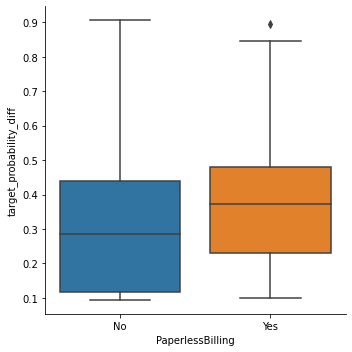

  Dependents  target_prediction_match
0         No                 0.774431
1        Yes                 0.886914


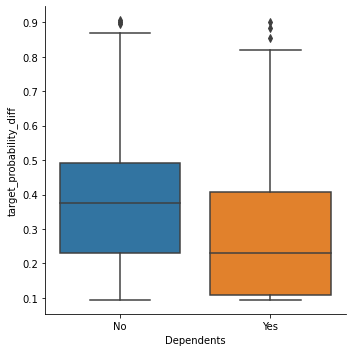

  SeniorCitizen  target_prediction_match
0             0                 0.822828
1             1                 0.730114


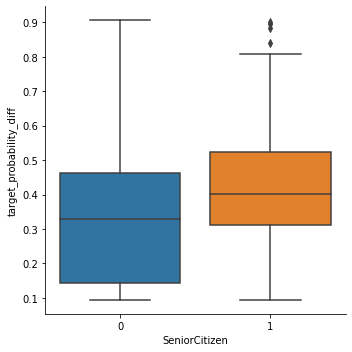

           TechSupport  target_prediction_match
0                   No                 0.722328
1  No internet service                 0.935412
2                  Yes                 0.858766


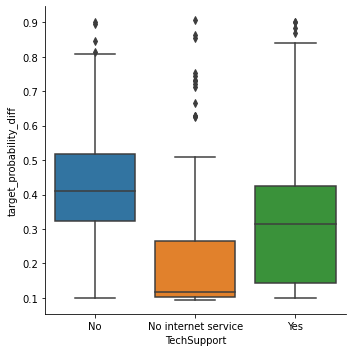

          OnlineBackup  target_prediction_match
0                   No                 0.737342
1  No internet service                 0.935412
2                  Yes                 0.819832


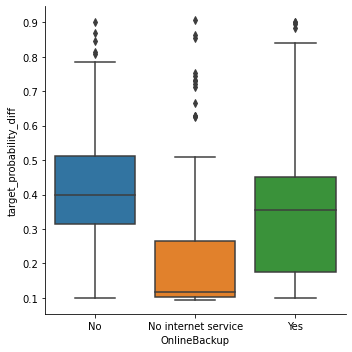

         Contract  target_prediction_match
0  Month-to-month                 0.703797
1        One year                 0.906921
2        Two year                 0.966601


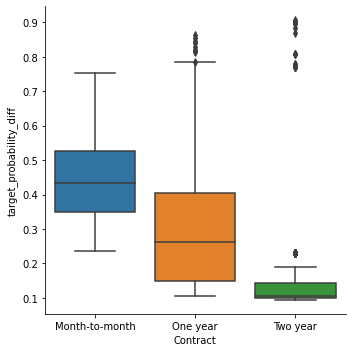

       StreamingMovies  target_prediction_match
0                   No                 0.736289
1  No internet service                 0.935412
2                  Yes                 0.811648


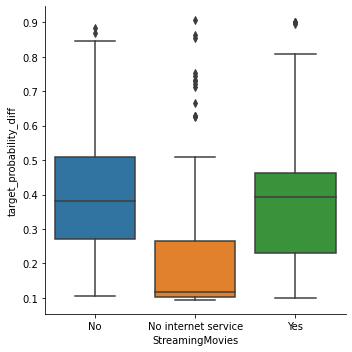

  Partner  target_prediction_match
0      No                 0.768812
1     Yes                 0.849505


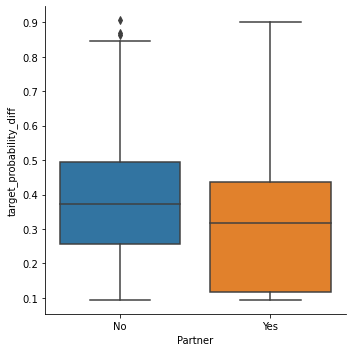

           StreamingTV  target_prediction_match
0                   No                 0.753187
1  No internet service                 0.935412
2                  Yes                 0.794007


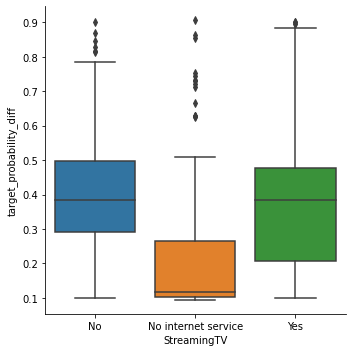

               PaymentMethod  target_prediction_match
0  Bank transfer (automatic)                 0.890830
1    Credit card (automatic)                 0.866521
2           Electronic check                 0.696710
3               Mailed check                 0.831663


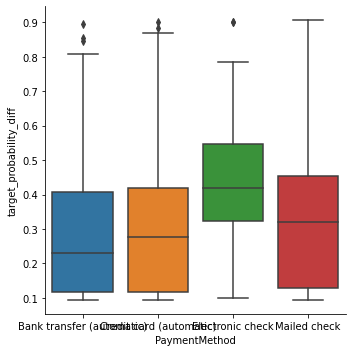

      DeviceProtection  target_prediction_match
0                   No                 0.723497
1  No internet service                 0.935412
2                  Yes                 0.833111


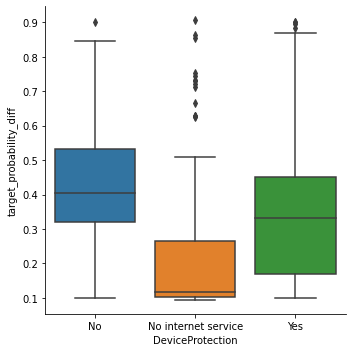

        OnlineSecurity  target_prediction_match
0                   No                 0.716714
1  No internet service                 0.935412
2                  Yes                 0.871074


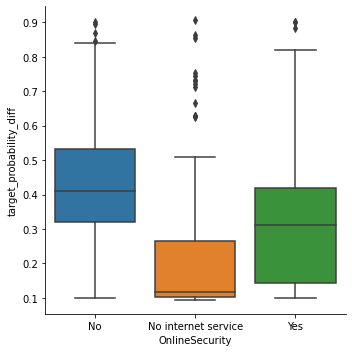

  InternetService  target_prediction_match
0             DSL                 0.823934
1     Fiber optic                 0.733191
2              No                 0.935412


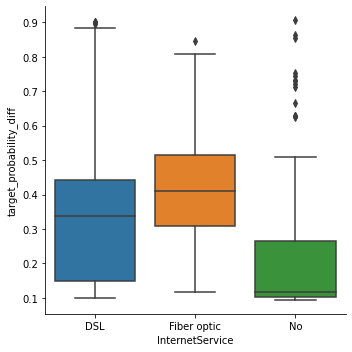

In [29]:
categorical_predictors = list(set(categorical_columns).intersection(set(error_analysis_data.columns)))
for categorical_predictor in categorical_predictors:
    print(error_analysis_data.groupby(categorical_predictor)['target_prediction_match'].mean().reset_index().to_string())
    sns.catplot(data=error_analysis_data, x=categorical_predictor, y="target_probability_diff", kind="box")
    plt.show()

   tenure_bins  target_prediction_match
0            0                 0.713075
1            1                 0.808786
2            2                 0.853933
3            3                 0.919118


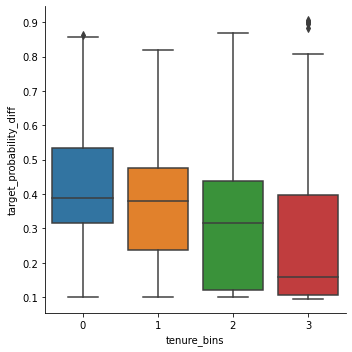

In [30]:
error_analysis_data['tenure_bins'] = list(pd.cut(error_analysis_data['tenure'], 4, retbins=False, labels=range(4)))

print(error_analysis_data.groupby('tenure_bins')['target_prediction_match'].mean().reset_index().to_string())
sns.catplot(data=error_analysis_data, x='tenure_bins', y="target_probability_diff", kind="box")
plt.show()

In [31]:
to_be_analyzed_categories = ['Contract', 
                             'PaymentMethod', 
                             'DeviceProtection', 
                             'SeniorCitizen', 
                             'TechSupport', 
                             'StreamingMovies', 
                             'InternetService', 
                             'OnlineSecurity']

In [32]:
for category in to_be_analyzed_categories:
    print(f'Column: {category}')
    print('Training')
    print(X_train[category].value_counts(normalize=True).to_string())

    print('Test')
    print(X_test[category].value_counts(normalize=True).to_string())
    
    print('---------------------------------------------------------------')

Column: Contract
Training
Month-to-month    0.545639
Two year          0.240568
One year          0.213793
Test
Month-to-month    0.560814
Two year          0.240890
One year          0.198296
---------------------------------------------------------------
Column: PaymentMethod
Training
Electronic check             0.337931
Mailed check                 0.225761
Bank transfer (automatic)    0.220284
Credit card (automatic)      0.216024
Test
Electronic check             0.330809
Mailed check                 0.236157
Bank transfer (automatic)    0.216753
Credit card (automatic)      0.216280
---------------------------------------------------------------
Column: DeviceProtection
Training
No                     0.442191
Yes                    0.339351
No internet service    0.218458
Test
No                     0.433034
Yes                    0.354472
No internet service    0.212494
---------------------------------------------------------------
Column: SeniorCitizen
Training
0    0.839757